In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import ydata_profiling as ydata

In [620]:
# Load dataset
df = pd.read_csv("../AI Talents League - Round 1/train.csv")

### 1. Exploratory Data Analysis (EDA) ###
print("Dataset Shape:", df.shape)
display(df.head())


Dataset Shape: (6000, 12)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.09
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.65
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,6.60
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.90


In [621]:
df.describe()

,X2,X4,X6,X8,Y
count,4994.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,12.956536,0.066333,141.228200,1997.840333,7.303403
std,4.658851,0.051492,62.540569,8.334412,1.014361
min,4.555000,0.000000,31.290000,1985.000000,3.510000
25%,8.895000,0.027030,94.037650,1987.000000,6.750000
50%,12.800000,0.054620,143.197000,1999.000000,7.500000
75%,17.100000,0.095154,186.522050,2004.000000,8.040000
max,21.350000,0.328391,266.888400,2009.000000,9.400000


In [622]:
ydata.ProfileReport(df).to_file("profile_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [623]:
df.duplicated().sum()

0

In [624]:
#Check for missing values
print("Missing Values Per Column %:")
print(df.isnull().sum()*100/len(df.index))

Missing Values Per Column %:
X1      0.000000
X2     16.766667
X3      0.000000
X4      0.000000
X5      0.000000
X6      0.000000
X7      0.000000
X8      0.000000
X9     28.516667
X10     0.000000
X11     0.000000
Y       0.000000
dtype: float64


In [625]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      6000 non-null   object 
 1   X2      4994 non-null   float64
 2   X3      6000 non-null   object 
 3   X4      6000 non-null   float64
 4   X5      6000 non-null   object 
 5   X6      6000 non-null   float64
 6   X7      6000 non-null   object 
 7   X8      6000 non-null   int64  
 8   X9      4289 non-null   object 
 9   X10     6000 non-null   object 
 10  X11     6000 non-null   object 
 11  Y       6000 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 562.6+ KB


In [626]:
# Feature Selection
X = df.drop(columns=["Y", "X1"])  # Drop Target and Unnecessary Column
y = df["Y"]

In [627]:
X["X9"].value_counts()

X9
Medium    1935
Small     1682
High       672
Name: count, dtype: int64

In [628]:
# Handling Missing Values
X["X9"] = X["X9"].fillna("Missing")
X["X2"] = X["X2"].fillna(X["X2"].mean())

In [629]:
# Identifying categorical & numerical features
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

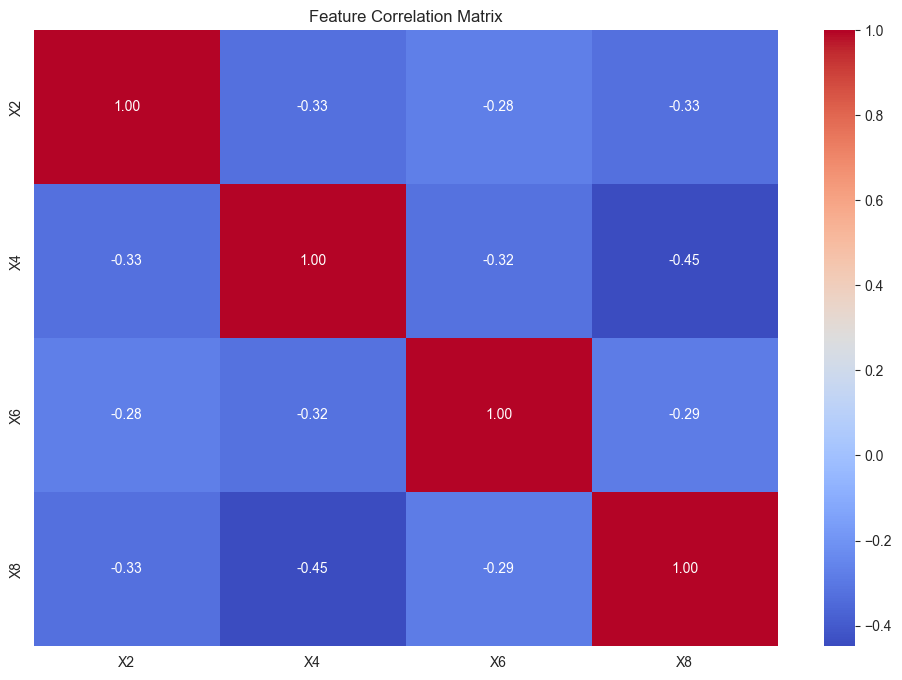

In [630]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
# Compute correlation matrix
corr_matrix = X[num_features].corr()
sns.heatmap(corr_matrix.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

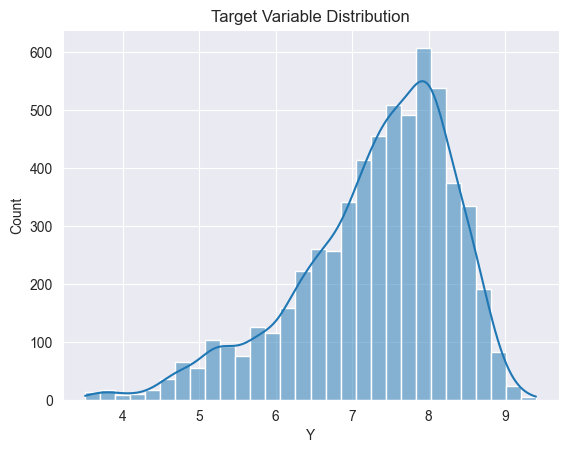

In [631]:
# Target Variable Distribution
sns.histplot(y, kde=True, bins=30)
plt.title("Target Variable Distribution")
plt.show()

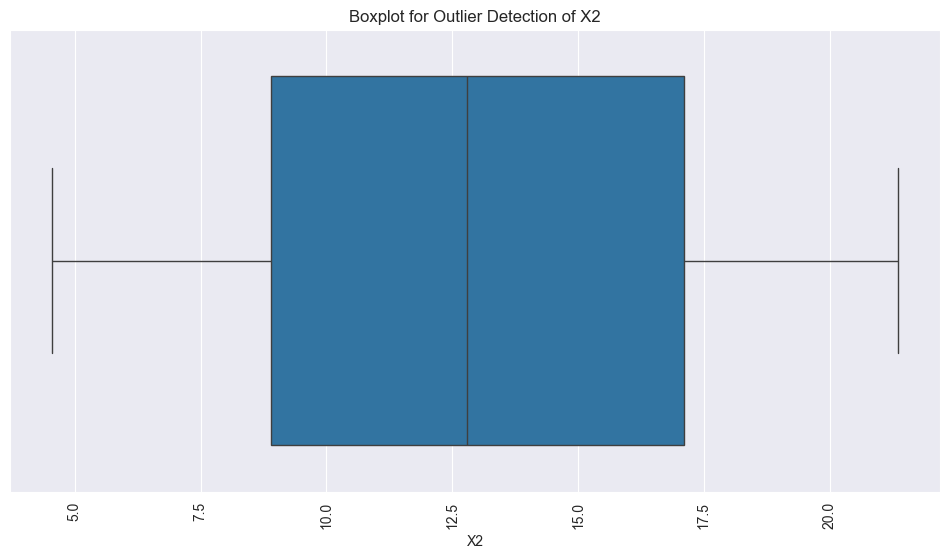

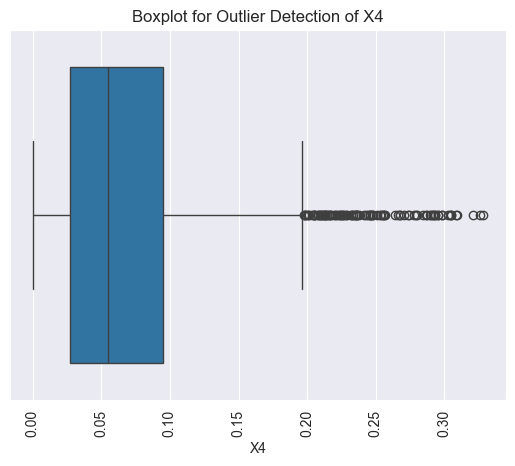

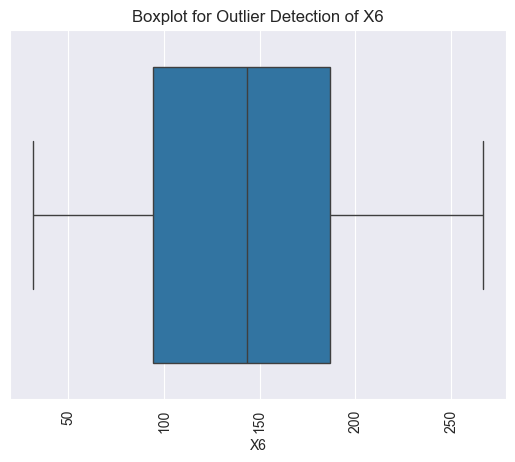

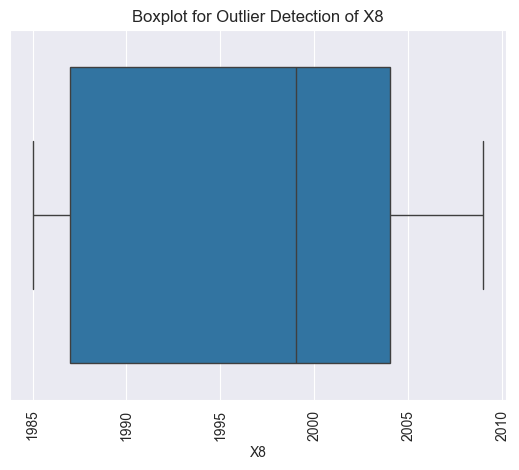

In [632]:
# Detect Outliers
plt.figure(figsize=(12, 6))
for col in num_features:
    sns.boxplot(data=df[[col]],  x=col)
    plt.xticks(rotation=90)
    plt.title(f"Boxplot for Outlier Detection of {col}")
    plt.show()

In [633]:
# Function to detect outliers using IQR
outliers = {}
for col in num_features:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for non-outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Detect outliers: data points outside the bounds
        outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
        num_outliers = outlier_condition.sum()

        # Calculate percentage of outliers
        outliers[col] = {
            'num_outliers': num_outliers,
            'percentage_outliers': (num_outliers / len(df)) * 100
        }

# Get outlier information for each numerical feature
outlier_info = outliers

# Print outliers information
for col, info in outlier_info.items():
    print(f"Feature: {col}")
    print(f"Number of Outliers: {info['num_outliers']}")
    print(f"Percentage of Outliers: {info['percentage_outliers']:.2f}%")
    print("-" * 40)

Feature: X2
Number of Outliers: 0
Percentage of Outliers: 0.00%
----------------------------------------
Feature: X4
Number of Outliers: 97
Percentage of Outliers: 1.62%
----------------------------------------
Feature: X6
Number of Outliers: 0
Percentage of Outliers: 0.00%
----------------------------------------
Feature: X8
Number of Outliers: 0
Percentage of Outliers: 0.00%
----------------------------------------


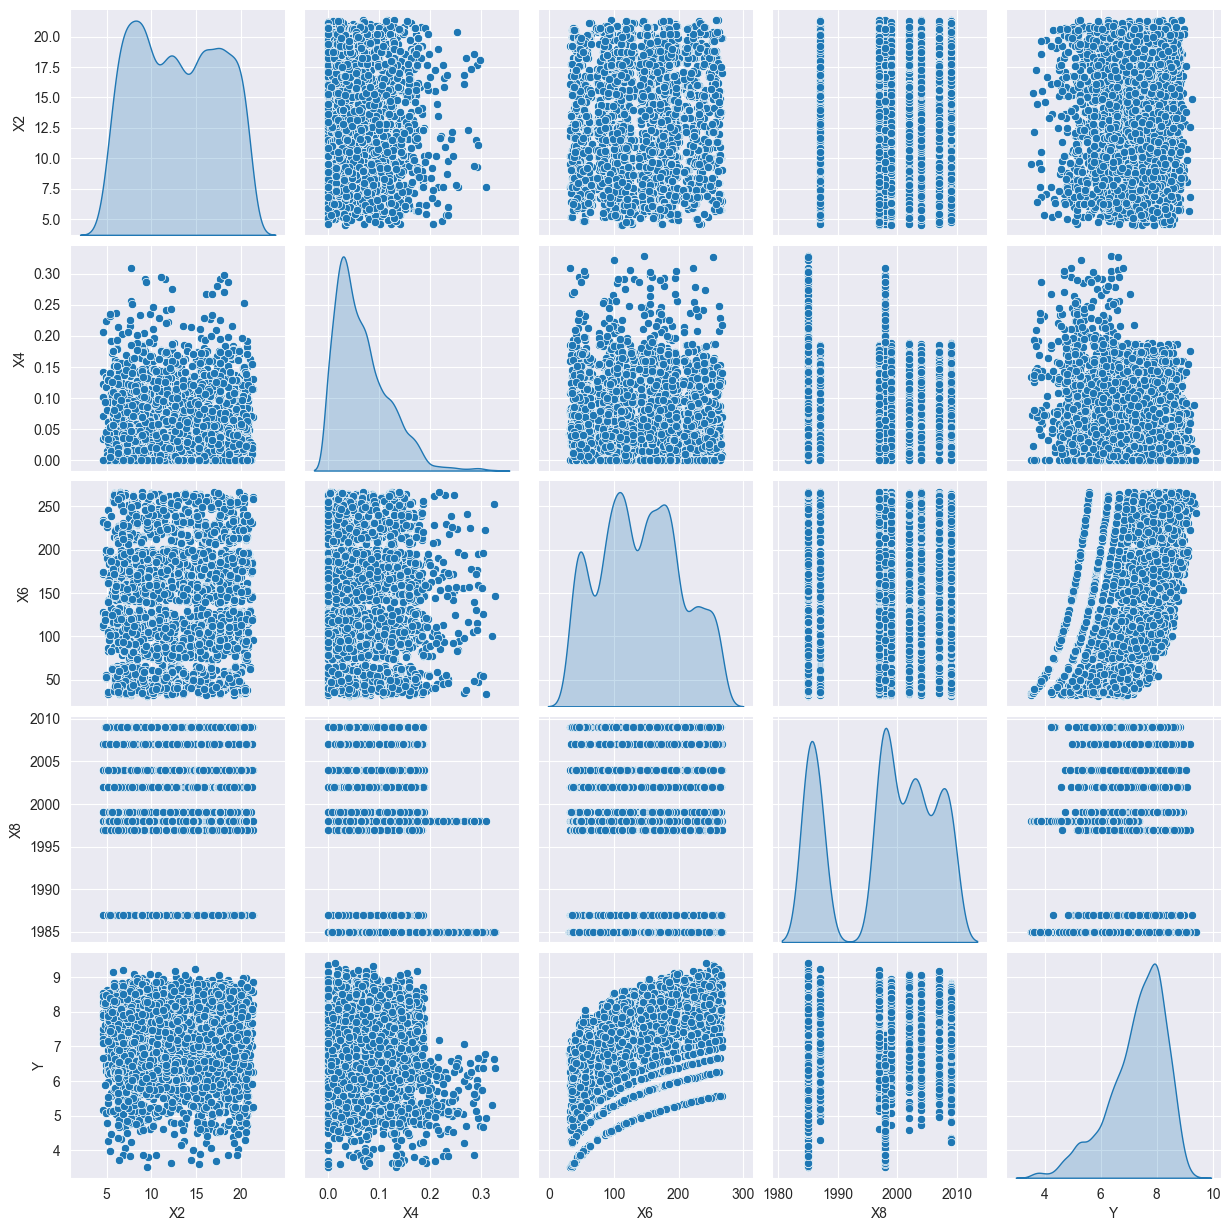

In [634]:
# Pairplot for Feature Relationships
sns.pairplot(df, diag_kind="kde")
plt.show()

In [635]:
# Binning Feature "X8" into categories
bins = [1980, 1990, 2000, 2010]
labels = ["Very Old", "Old", "Recent"]
X["X8"] = pd.cut(df["X8"], bins=bins, labels=labels)

In [636]:
transformer = PowerTransformer(method='yeo-johnson')
#y=transformer.fit_transform(target.values.reshape(-1,1))
#y = target.ravel()

In [637]:
X["X4"]=transformer.fit_transform(X["X4"].values.reshape(-1,1))

In [638]:
# Identifying categorical & numerical features
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()


In [639]:
# Scaling Numerical Features
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

In [640]:
# Standardizing the values to two categories: 'Low Fat' and 'Regular'
X["X3"] = X["X3"].str.lower().str.strip()  # Convert to lowercase and remove extra spaces

# Map different spellings to a consistent format
X["X3"] = X["X3"].replace({
    'low fat': 'Low Fat',
    'lf': 'Low Fat',
    'regular': 'Regular',
    'reg': 'Regular'
})

In [641]:
 Encoding Categorical Features
ordinal_encoders = {
   "X9": OrdinalEncoder(categories=[["Missing", "Small", "Medium", "High"]]),
   "X8": OrdinalEncoder(categories=[["Very Old", "Old", "Recent"]])
}

for col, encoder in ordinal_encoders.items():
    X[col] = encoder.fit_transform(X[[col]])

In [642]:
# One-Hot Encoding Other Categorical Features
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_features = one_hot_encoder.fit_transform(X[["X3", "X5", "X7", "X10", "X11"]])
one_hot_df = pd.DataFrame(one_hot_features, columns=one_hot_encoder.get_feature_names_out())
X = X.drop(columns=["X3", "X5", "X7", "X10", "X11"]).reset_index(drop=True)
X = pd.concat([X, one_hot_df.reset_index(drop=True)], axis=1)


In [643]:
X

,X2,X4,X6,X8,X9,X3_Low Fat,X3_Regular,X5_Baking Goods,X5_Breads,X5_Breakfast,...,X7_OUT045,X7_OUT046,X7_OUT049,X10_Tier 1,X10_Tier 2,X10_Tier 3,X11_Grocery Store,X11_Supermarket Type1,X11_Supermarket Type2,X11_Supermarket Type3
0,-0.860371,-1.152872,1.736314,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.655674,-1.043439,-1.486503,2.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.069063,-1.128442,0.006233,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.469067,-1.748998,0.653499,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.947431,-1.748998,-1.397078,0.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.798483,-0.902626,-0.742786,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5996,-0.885077,1.084295,-1.320910,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5997,-0.532132,0.039085,-1.291663,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5998,0.657293,-0.031651,0.873378,2.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [644]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [645]:
# Define the parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'alpha': [0.1, 1, 10, 100],
        'solver': ['auto', 'saga', ]
    },
    'Lasso Regression': {
        'alpha': [0.01, 0.1, 0.5, 1, 10],
        'max_iter': [1000, 2000, 3000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [ 'sqrt', 'log2']
    },
    'Gradient Boosting': {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 10],
        'subsample': [0.7, 0.8, 0.9]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.3, 0.],
        'gamma': [0, 0.1],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 5],
        'min_child_weight': [1, 3]
    },

    'Support Vector Regression': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'epsilon': [0.01, 0.05, 0.1, 0.2]
    }
}

In [646]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    #'XGBoost':XGBRegressor(tree_method='hist'),
    'Support Vector Regression': SVR()
}

In [647]:
best_results = {}
best_models = {}

# Perform GridSearchCV for each model

for name, model in tqdm(models.items(), desc="Training Models"):
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=3)
    grid_search.fit(X_train, y_train)
    best_results[name] = -grid_search.best_score_  # Negating the score to convert back from negative MAE
    best_models[name] = grid_search.best_estimator_

# Print out the best results
for name in best_results:
    print(f"{name}: Best MAE = {best_results[name]}")

# Select the best model
best_model_name = min(best_results, key=best_results.get)
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name} with MAE of {best_results[best_model_name]}")


Training Models:   0%|          | 0/6 [00:00<?, ?it/s]

Running GridSearchCV for Linear Regression...


Training Models:  17%|█▋        | 1/6 [00:02<00:10,  2.12s/it]

Running GridSearchCV for Ridge Regression...


Training Models:  33%|███▎      | 2/6 [00:03<00:06,  1.69s/it]

Running GridSearchCV for Lasso Regression...


Training Models:  50%|█████     | 3/6 [00:04<00:04,  1.40s/it]

Running GridSearchCV for Random Forest...


/Users/tarekahmed/miniconda3/envs/new_env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Training Models:  67%|██████▋   | 4/6 [06:47<05:19, 159.82s/it]

Running GridSearchCV for Gradient Boosting...


Training Models:  83%|████████▎ | 5/6 [16:31<05:12, 312.90s/it]

Running GridSearchCV for Support Vector Regression...


Training Models: 100%|██████████| 6/6 [22:11<00:00, 222.00s/it]

Linear Regression: Best MAE = 0.44530220291989114
Ridge Regression: Best MAE = 0.4434701437355753
Lasso Regression: Best MAE = 0.44583465347742857
Random Forest: Best MAE = 0.44665249748827335
Gradient Boosting: Best MAE = 0.4276515618409201
Support Vector Regression: Best MAE = 0.4277557203760294
Best Model: Gradient Boosting with MAE of 0.4276515618409201


In [648]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted':y_train})
df2 = df1.head(10)
df2.plot(kind = 'bar')

ValueError: All arrays must be of the same length

In [612]:
test_df=pd.read_csv("../AI Talents League - Round 1/test.csv")
test_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,FDO37,NaN,Low Fat,0.021273,Breakfast,229.1326,OUT027,1985,Medium,Tier 3,Supermarket Type3
1,FDV13,17.35,Regular,0.027588,Canned,86.1856,OUT013,1987,High,Tier 3,Supermarket Type1
2,FDF52,9.30,Low Fat,0.111782,Frozen Foods,182.3292,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDY11,6.71,Regular,0.029606,Baking Goods,65.4142,OUT049,1999,Medium,Tier 1,Supermarket Type1
4,FDL20,17.10,Low Fat,0.129141,Fruits and Vegetables,109.4886,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [613]:
test_df.drop(columns=["X1"], inplace=True)
test_df["X3"].unique()


array(['Low Fat', 'Regular', 'LF', 'low fat', 'reg'], dtype=object)

In [614]:
# Standardizing the values to two categories: 'Low Fat' and 'Regular'
test_df["X3"] = test_df["X3"].str.lower().str.strip()  # Convert to lowercase and remove extra spaces

# Map different spellings to a consistent format
test_df["X3"] = test_df["X3"].replace({
    'low fat': 'Low Fat',
    'lf': 'Low Fat',
    'regular': 'Regular',
    'reg': 'Regular'
})


In [615]:
test_df.isnull().sum()/len(df)


X2     0.076167
X3     0.000000
X4     0.000000
X5     0.000000
X6     0.000000
X7     0.000000
X8     0.000000
X9     0.116500
X10    0.000000
X11    0.000000
dtype: float64

In [616]:
test_df.fillna({"X2": test_df["X2"].mean(), "X9": "Missing"}, inplace=True)
test_df["X8"] = pd.cut(test_df["X8"], bins=bins, labels=labels)

In [617]:
numerical_features=test_df.select_dtypes(include=[np.number]).columns.tolist()
catergical_features=test_df.select_dtypes(exclude=[np.number]).columns.tolist()

test_df["X4"]=transformer.fit_transform(test_df["X4"].values.reshape(-1,1))

test_df[numerical_features]=scaler.fit_transform(test_df[numerical_features])

ordinal_enconder_X9=OrdinalEncoder(categories=[['Missing','Small', 'Medium', 'High']])
test_df["X9"]=ordinal_enconder_X9.fit_transform(test_df[["X9"]])
ordinal_enconder_X8=OrdinalEncoder(categories=[['Very Old', 'Old', 'Recent']])
test_df["X8"]=ordinal_enconder_X8.fit_transform(test_df[["X8"]])

one_hot_encoder=OneHotEncoder(handle_unknown='ignore',sparse_output=False)
categorical_cols=['X3','X5','X7','X10','X11']
one_hot_features=one_hot_encoder.fit_transform(test_df[categorical_cols])
one_hot_df=pd.DataFrame(one_hot_features,columns=one_hot_encoder.get_feature_names_out(categorical_cols))

# Reset index to match original DataFrame
one_hot_df.index = test_df.index

# Drop original categorical columns
test_df.drop(columns=categorical_cols, inplace=True)

# Concatenate the new one-hot encoded DataFrame with the original features
test_df = pd.concat([test_df, one_hot_df], axis=1)
test_df

,X2,X4,X6,X9_Medium,X9_Missing,X9_Small,X8_Old,X8_Recent,X3_Low Fat,X3_Regular,...,X7_OUT045,X7_OUT046,X7_OUT049,X10_Tier 1,X10_Tier 2,X10_Tier 3,X11_Grocery Store,X11_Supermarket Type1,X11_Supermarket Type2,X11_Supermarket Type3
0,0.000000,-0.856025,1.439099,True,False,False,False,False,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.137322,-0.734224,-0.880130,False,False,False,False,False,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.797718,0.889736,0.679742,False,True,False,True,False,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,-1.420297,-0.695290,-1.217134,True,False,False,True,False,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.077228,1.224571,-0.502053,False,True,False,False,True,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,-1.383038,-0.171089,1.202047,False,False,False,False,False,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2519,-1.018866,-0.360134,-0.523657,False,True,False,False,True,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2520,-0.485227,-0.587663,-0.897380,False,False,True,False,True,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2521,-1.300108,1.534723,-0.605166,True,False,False,False,True,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [618]:
y_pred = best_model.predict(test_df)
pd.DataFrame({'row_id': test_df.index, 'Y': y_pred}).to_csv('../AI Talents League - Round 1/predictionsTXGBOOST.csv', index=False)
